# MVTec Anomaly Detection Tutorial using Anomalib (v2.0.0)

### Introduction
This notebook walks through anomaly detection using the **MVTec AD dataset** and the **Anomalib** library (v2.0.0). Anomaly detection is the task of identifying unusual patterns or outliers in data, crucial for tasks like spotting defects in manufacturing. Since defects are rare and diverse, we typically train models on only normal (defect-free) images and then flag anything that deviates significantly. The core idea is to learn the characteristics of "normal" and identify what doesn't fit this learned pattern. This is particularly valuable in real-world scenarios like manufacturing, medicine, and security where obtaining examples of all possible defects is challenging.

#### What is MVTec AD?
MVTec AD is a widely-used benchmark dataset for evaluating anomaly detection systems in a real-world industrial context. It comprises over 5000 high-resolution images across 15 categories of objects and textures. For each category, the dataset provides a training set containing *only* normal, defect-free images, and a test set that includes both normal images and images with various types of defects, accompanied by pixel-precise labels of the defect regions. The standard task is to train on the normal images of one category and predict anomalies in the test set, producing image-level scores and pixel-level anomaly maps.

#### What is Anomalib?
Anomalib is an open-source Python library, built on PyTorch Lightning, that collects state-of-the-art anomaly detection algorithms for images. Its focus is on visual anomaly detection – specifically, detecting and localizing defects in images or video frames. Anomalib provides ready-to-use implementations of many published methods, along with utilities for data handling, experiment logging, and evaluation (including metrics like AUROC for image and pixel levels), streamlining the process of building and experimenting with anomaly detection systems.

* * *

### Setting up the Environment

Getting started with Anomalib requires setting up the necessary software environment. This involves installing the `anomalib` library itself, which provides the core functionalities for loading datasets, defining state-of-the-art models, and managing the training and evaluation workflows. The `[full]` option ensures that all components needed for various features and dependencies, such as those for data handling and evaluation metrics, are included. Anomalib is built on PyTorch Lightning and typically requires Python 3.8+ and a GPU for practical use and reasonable speed.

In [ ]:
!pip install anomalib[full] -q

This command installs `anomalib` along with its extra dependencies. In a Google Colab environment, you might need to restart the runtime after installation for all installed packages to be correctly recognized. Using a virtual environment or conda is generally recommended to manage dependencies. While smaller models can be trained on free Colab GPUs, training larger models or on larger datasets might require more powerful hardware or utilizing multi-GPU support if available.

### Importing Python Modules

We import the key classes and functions from Anomalib and other standard libraries that will be used throughout this notebook. This includes the specific class for handling the MVTec AD dataset (`MVTecAD`), definitions for different anomaly detection models like `Padim` and `Dfkde` (Patch Distribution Modeling and Deep Feature Kernel Density Estimation), the central `Engine` from `anomalib.engine` that orchestrates the machine learning pipeline, and common libraries such as `matplotlib` for plotting, `numpy` for numerical operations, `cv2` for image processing, and `torch` for tensor computations. These imports provide the building blocks for our anomaly detection pipeline and for visualizing the results, including anomaly maps and masks.

In [ ]:
from anomalib.data import MVTecAD
from anomalib.models import Padim, Dfkde
from anomalib.engine import Engine
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch

/usr/local/lib/python3.11/dist-packages/openvino/runtime/__init__.py:10: DeprecationWarning: The `openvino.runtime` module is deprecated and will be removed in the 2026.0 release. Please replace `openvino.runtime` with `openvino`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


# Preparing the MVTec AD Dataset

The MVTec AD dataset is a cornerstone for evaluating image anomaly detection methods. It's structured into 15 different categories, representing various objects and textures. For this tutorial, we define the base directory where the dataset will be stored or accessed. Each category within the dataset represents a distinct anomaly detection problem, where models are trained to distinguish normal items of that category from defective ones and produce corresponding anomaly maps and scores.

In [ ]:
root = "./datasets/MVTecAD"  # ✅ not the screw folder itself
category = "screw"

# LOADING THE DATASET

Anomalib's `MVTecAD` class streamlines the process of accessing and preparing the dataset. By specifying the `root` directory and the desired `category` (here, "screw"), this class automatically handles downloading the dataset (if it's not already present), applying necessary image transformations, and setting up PyTorch DataLoaders for both the training and test splits. A critical aspect for unsupervised anomaly detection models is that the training split provided by this DataModule consists *exclusively* of images depicting normal, defect-free instances of the chosen category. The test set includes both normal and anomalous images, allowing for evaluation of how well the model detects unseen defects and generates accurate anomaly maps and image-level scores.

In [ ]:
dataset = MVTecAD(
    root=root,
    category=category,
    train_batch_size=32,
    eval_batch_size=32,
    num_workers=2,
)

### BEHIND THE SCENES:
This step prepares the dataset by organizing the images into efficient DataLoaders for training and testing. The DataModule is designed to feed the training process only with normal images, enabling the model to learn the distribution of "normal" appearances without seeing any defects. The test set, however, contains a mix of normal and anomalous images, allowing us to evaluate the model's ability to detect unseen defects and generate outputs like anomaly maps and prediction masks.

# CHOOSING AND INITIALIZING THE PaDiM MODEL

Our first model for this tutorial is PaDiM (Patch Distribution Modeling). PaDiM is a popular choice known for its simplicity, memory efficiency, and speed. It leverages a pre-trained convolutional neural network backbone, such as ResNet18, as a fixed feature extractor. The core idea is to model the statistical distribution of features extracted from patches across normal training images. PaDiM is generally faster at inference compared to other methods.

In [ ]:
padim_model = Padim(backbone="resnet18")  # or Dfkde()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### EXPLANATION:
PaDiM works by passing input images through a pre-trained backbone and extracting features from intermediate layers. For each spatial location (corresponding to a patch) across the training set, it fits a multivariate Gaussian distribution to the feature vectors. This learns a statistical model of what "normal" features look like at every location. During inference, the Mahalanobis distance between a test patch's features and the learned Gaussian distribution is calculated – a high distance indicates an anomaly. These patch-level scores are combined into an anomaly map. PaDiM is efficient because it only stores the mean and covariance parameters of these distributions. DFKDE is a related model that uses Kernel Density Estimation instead of Gaussian fitting. PaDiM's anomaly maps tend to highlight anomalous regions based on deviations from local feature distributions.

# Training the PaDiM Model

With the dataset loaded and the model initialized, we use Anomalib's `Engine` to manage the training process. Calling `engine.fit(model=padim_model, datamodule=dataset)` starts the training loop, utilizing only the normal images provided by the datamodule.

In [ ]:
engine = Engine()
engine.fit(model=padim_model, datamodule=dataset)

INFO:lightning_fabric.utilities.rank_zero:GPU available: False, used: False
INFO:lightning_fabric.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning_fabric.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:lightning_fabric.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
INFO: 
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | pre_processor  | PreProcessor  | 0      | train
1 | post_processor | PostProcessor | 0      | train
2 | evaluator      | Evaluator     | 0      | train
3 | model          | PadimModel    | 2.8 M  | train
---------------------------------------------------------
2.8 M     Trainable params
0         Non-trainable params


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


### BEHIND THE SCENES:
- The `engine.fit()` method orchestrates the training, which for PaDiM is a non-iterative process.
- During PaDiM training, the model performs a forward pass on all normal training images.
- It extracts features from specified layers of the backbone.
- It then computes and stores the mean vector and covariance matrix for the feature vectors observed at each spatial location across the entire training set. This is the core learning step for PaDiM – building the statistical model of normal features.
- No gradient descent or backpropagation is involved in PaDiM's training; it's primarily a data aggregation step. The result of training is the learned statistical parameters used for anomaly scoring during inference.

# Evaluating the PaDiM Model

After the PaDiM model has built its statistical model of normal features, we evaluate its ability to detect anomalies on the test set. The test set contains a mix of normal and defective images that the model has not seen before. Calling `engine.predict(model=padim_model, datamodule=dataset)` runs inference on this set.

In [ ]:
results = engine.predict(model=padim_model, datamodule=dataset)

INFO:lightning_fabric.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor


Predicting: |          | 0/? [00:00<?, ?it/s]

### EXPLANATION:
When `engine.predict()` is called, the model processes each test image. For PaDiM, this means extracting features and calculating the Mahalanobis distance of each patch's features to the learned normal distribution. The output `results` object contains the model's predictions for each test sample. Key outputs include the original test `image`, a pixel-wise `anomaly_map` where higher values indicate greater anomaly likelihood, and a binary `pred_mask` derived by thresholding the anomaly map, which attempts to segment the anomalous regions. The anomaly map provides a visual indication of where defects might be located, and the prediction mask gives a binary segmentation. These outputs are essential for quantitatively evaluating performance (e.g., using AUROC for both image and pixel levels) and visually inspecting detected anomalies.

# VISUALIZING A DETECTED DEFECTIVE SAMPLE

Visualizing the model's output on test images is crucial for understanding its performance beyond just metrics. It allows us to see *where* the model is detecting anomalies and how the anomaly map and mask look. We define a utility function to help display the original image, the model's anomaly map, its predicted anomaly mask, and an overlay showing the detected anomaly on the original image. This helps assess both detection and localization quality visually.

In [ ]:
def show_result(sample):
    img = sample.image[0] if sample.image.dim() == 4 else sample.image
    img = img.permute(1, 2, 0).cpu().numpy().clip(0, 1)

    anomaly_map = sample.anomaly_map[0].cpu().numpy()
    pred_mask = sample.pred_mask[0]

    # Normalize anomaly map
    anomaly_map_norm = (anomaly_map - anomaly_map.min()) / (anomaly_map.max() - anomaly_map.min() + 1e-8)

    # Fix the resizing error
    pred_mask_np = pred_mask.cpu().numpy().astype(np.uint8)
    pred_mask_resized = cv2.resize(pred_mask_np, (img.shape[1], img.shape[0]))

    # Overlay anomaly in red
    overlay = img.copy()
    overlay[pred_mask_resized > 0.5] = [1.0, 0.0, 0.0]

    # Plot
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 4, 1); plt.title("Original"); plt.imshow(img); plt.axis("off")
    plt.subplot(1, 4, 2); plt.title("Anomaly Map"); plt.imshow(anomaly_map_norm, cmap="jet"); plt.axis("off"); plt.colorbar()
    plt.subplot(1, 4, 3); plt.title("Prediction Mask"); plt.imshow(pred_mask_resized, cmap="gray"); plt.axis("off")
    plt.subplot(1, 4, 4); plt.title("Overlay"); plt.imshow(overlay); plt.axis("off")
    plt.tight_layout(); plt.show()

### Inspecting a Detected Anomaly (PaDiM)

Here, we apply our visualization function to a test sample. We iterate through the prediction `results` from the PaDiM model and look for the first instance where the model's predicted mask indicates the presence of an anomaly (i.e., the sum of the mask pixels is greater than zero). Once such a sample is found, the `show_result` function is called to display its results, giving a visual example of PaDiM's anomaly detection on a defective item from the "screw" category. You can observe how the anomaly map highlights the defect area and the prediction mask attempts to segment it. The `break` statement ensures only the first detected anomaly is shown in this instance.

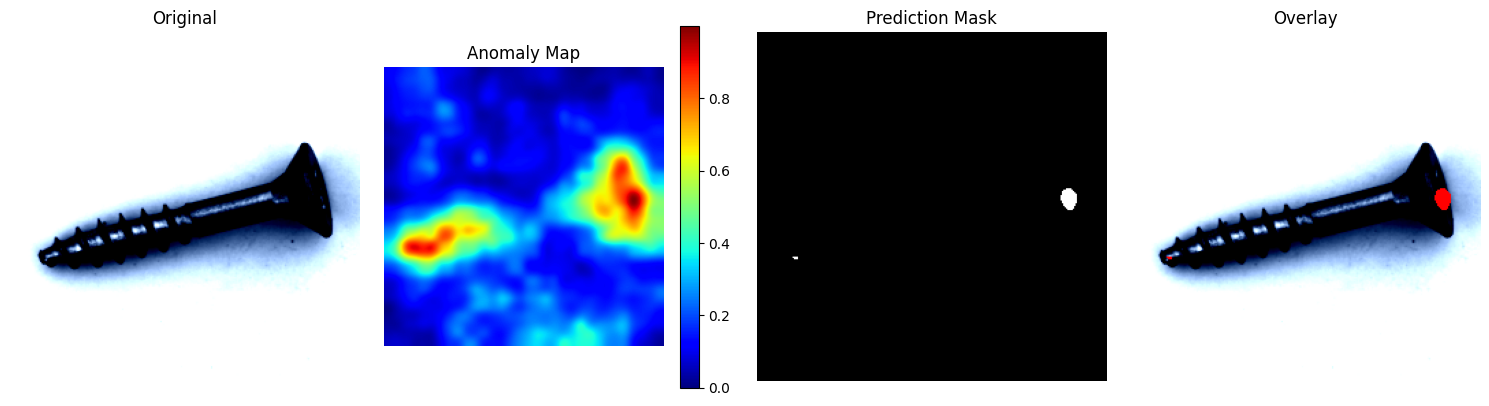

In [ ]:
# Show first defective sample (if any)

for r in results:
    if r.pred_mask[0].sum() > 0:
        show_result(r)
        break

## Part 2: Exploring Pixel Anomaly Detection with FastFlow on 'tile'

Moving beyond the statistical approach of PaDiM, we now explore the FastFlow model, a generative-style method available in Anomalib. FastFlow is particularly strong for pixel-level anomaly localization and is often applied to texture datasets like the "tile" category from MVTec AD. It uses normalizing flows to learn a more complex and flexible model of the normal feature distribution. FastFlow has been shown to achieve state-of-the-art detection accuracy on MVTec AD.

In [ ]:
category = "tile"

tile_dataset = MVTecAD(
    root=root,
    category=category,
    train_batch_size=32,
    eval_batch_size=32,
    num_workers=2,
)

### Initializing the FastFlow Model

The FastFlow model is initialized, often with a pre-trained backbone like ResNet18. Instead of simple statistics like PaDiM, FastFlow employs normalizing flows—a sequence of invertible transformations—to learn a sophisticated probability model of normal features. This allows it to capture more complex data distributions. During inference, it determines how likely a test patch's features are under this learned model; low likelihood (density) is indicative of an anomaly. FastFlow excels at modeling complex distributions and generating clear anomaly maps.

In [ ]:
from anomalib.models import Fastflow

fastflow_model = Fastflow(backbone="resnet18")

### Training the FastFlow Model

Using the `Anomalib Engine`, we train the FastFlow model on the normal images from the "tile" dataset. FastFlow's training is an iterative optimization process that focuses on learning the parameters of the normalizing flows. The goal is to build a model that assigns high probability density to features from normal images and low density to features from anomalous ones. Training for a sufficient number of epochs (here set to 20) is important for the flows to accurately model the complex normal distribution. The training process optimizes the model to produce low anomaly scores (high likelihood) for normal data.

In [ ]:
engine = Engine(max_epochs=20)
engine.fit(model=fastflow_model, datamodule=tile_dataset)

INFO:lightning_fabric.utilities.rank_zero:GPU available: False, used: False
INFO:lightning_fabric.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning_fabric.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | pre_processor  | PreProcessor  | 0      | train
1 | post_processor | PostProcessor | 0      | train
2 | evaluator      | Evaluator     | 0      | train
3 | model          | FastflowModel | 7.7 M  | train
4 | loss           | FastflowLoss  | 0      | train
---------------------------------------------------------
3.5 M     Trainable params
4.2 M     Non-trainable params
7.7 M     Total params
30.678    Total estimated model params size (MB)
267       Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
-----------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/core/module.py:512: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


### Evaluating FastFlow's Performance

After training, `engine.predict()` evaluates the FastFlow model on the "tile" test set. FastFlow computes the probability density of the test image features under the learned normalizing flow model. Regions with low density are assigned high anomaly scores, resulting in anomaly maps. FastFlow's anomaly maps are often smooth and tend to provide strong separation between normal and anomalous areas, making them effective for localizing defects on textures. The output includes these anomaly maps and corresponding prediction masks after thresholding.

In [ ]:
tile_results = engine.predict(model=fastflow_model, datamodule=tile_dataset)

INFO:lightning_fabric.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor


Predicting: |          | 0/? [00:00<?, ?it/s]

### Inspecting a Detected Anomaly (FastFlow)

Here, we find and visualize the results for the first test sample in the "tile" category where the FastFlow model detected an anomaly. Using the `show_result` function, we can examine the original image, FastFlow's smooth anomaly map, the predicted anomaly mask (obtained by thresholding the map), and the overlay. This visual inspection helps us assess how effectively FastFlow detects and localizes defects on a texture dataset, where anomalies can be subtle. You can compare the characteristics of the anomaly map produced by FastFlow to that of PaDiM – FastFlow maps are often smoother and provide clearer separation.

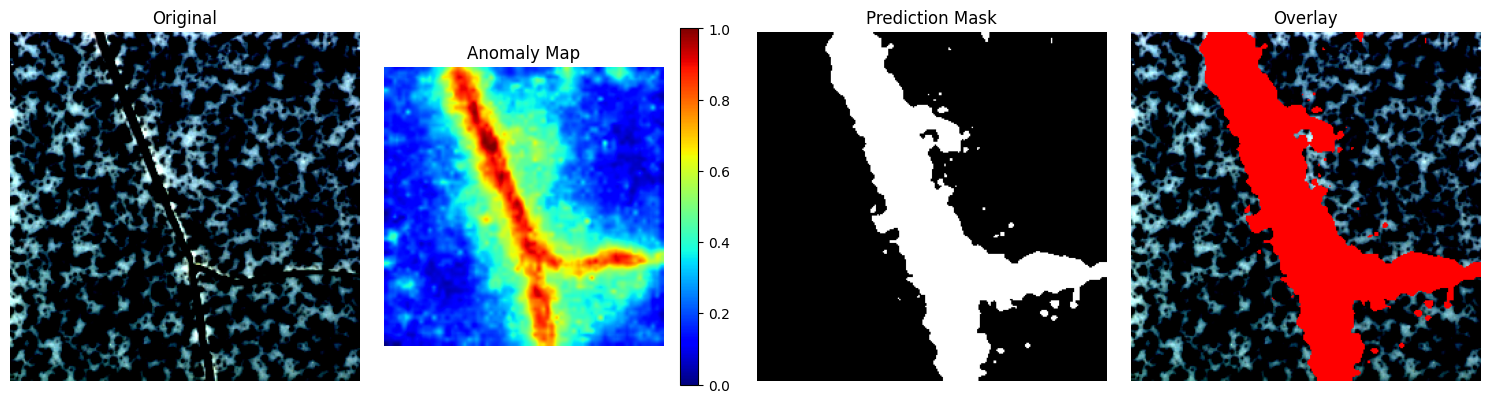

In [ ]:
for r in tile_results:
    if r.pred_mask[0].sum() > 0:
        show_result(r)
        break

## Part 3: Delving into PatchCore for Anomaly Detection

In the final section, we explore PatchCore, another leading anomaly detection method available in Anomalib. PatchCore is a memory-based approach known for its high accuracy and ability to precisely localize anomalies at the pixel level. It operates by building a memory bank of features from normal patches. We will apply this model to the "bottle" category of the MVTec AD dataset, which features objects rather than textures. PatchCore often rivals FastFlow in overall detection performance and produces very clear anomaly maps.

In [ ]:
category = "bottle"

bottle_dataset = MVTecAD(
    root=root,
    category=category,
    train_batch_size=32,
    eval_batch_size=8,
    num_workers=8,
)

### Initializing the PatchCore Model

The PatchCore model is initialized, using a pre-trained backbone (ResNet18 in this case) and specifying which layers to extract features from (`layers=["layer2", "layer3"]`). PatchCore builds a memory bank containing a representative subset of features extracted from normal training image patches. To manage memory usage, it employs coreset sampling; the `coreset_sampling_ratio=0.1` parameter means that only 10% of the extracted normal features will be kept in the memory bank. Anomaly detection is then based on the nearest-neighbor distance of test patch features to this compact memory bank. PatchCore often requires more GPU RAM for the feature bank but provides high accuracy.

In [ ]:
from anomalib.models import Patchcore

patchcore_model = Patchcore(backbone="resnet18", layers=["layer2", "layer3"], coreset_sampling_ratio=0.1)

### Training the PatchCore Model

Training the PatchCore model is different from the iterative optimization used by PaDiM or FastFlow. It primarily involves performing a forward pass on all normal training images, extracting features from the specified layers, and then constructing the coreset memory bank by selecting a representative subset of these features. The `Anomalib Engine` manages this process, which is largely a one-time data aggregation and selection step to build PatchCore's reference memory of normal appearances.

In [ ]:
engine_pc = Engine(max_epochs=1)
engine_pc.fit(model=patchcore_model, datamodule=bottle_dataset)

### Evaluating PatchCore's Performance

Using `engine.predict()`, we evaluate the trained PatchCore model on the "bottle" test set. This involves extracting features from test images and computing their distance to the nearest neighbors within the constructed memory bank of normal features. A large distance suggests that a test patch's features are unlike anything seen in the normal training data. This process yields precise anomaly scores and detailed anomaly maps, which often highlight anomalous pixels accurately due to the direct comparison with a memory of normal examples. The output includes these precise anomaly maps and the corresponding prediction masks.

In [ ]:
bottle_results = engine_pc.predict(model=patchcore_model, datamodule=bottle_dataset)

INFO:lightning_fabric.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor


Predicting: |          | 0/? [00:00<?, ?it/s]

### Inspecting a Detected Anomaly (PatchCore)

Finally, we visualize a test sample from the "bottle" category where the PatchCore model detected an anomaly. Using the `show_result` function, we can examine the original image and PatchCore's outputs (anomaly map, predicted mask, and overlay). This allows for a visual assessment of PatchCore's detection and localization capabilities on object images, observing how its memory-based approach identifies defects by finding test patches that are distant from known normal examples. Note the potentially more precise highlighting of anomalous regions compared to PaDiM and FastFlow.

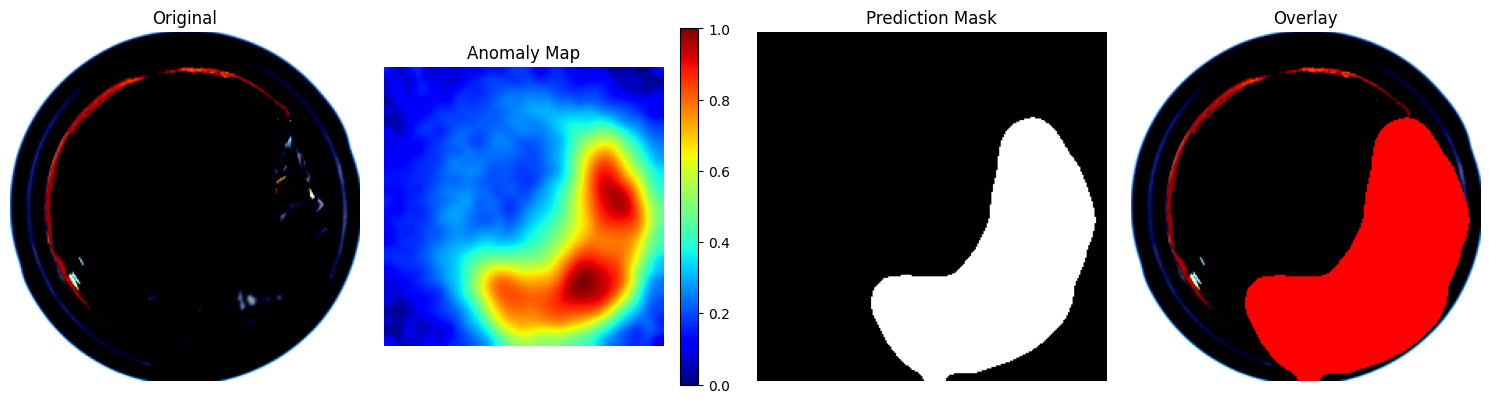

In [ ]:
for r in bottle_results:
    if r.pred_mask[0].sum() > 0:
        show_result(r)
        break